# Sinus samples







## Dataset

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch.utils.data import Dataset

In [ ]:
class SinusSamplesDataset(Dataset):

    def __init__(self, nb_examples, fs, frequency_range, len_sinus):
        self.nb_examples = nb_examples
        self.fs = fs
        self.frequency_range = frequency_range
        self.len_sinus = len_sinus
        self.samples = self.sinus_generator(self.nb_examples, self.fs, self.frequency_range, self.len_sinus)


    def __len__(self):
        return self.samples.size()[0]

    def __getitem__(self, item):
        return self.samples[item]

    def sinus_generator(self, nb_examples, fs, frequency_range, len_sinus):
        # create samples array
        samples = np.zeros((nb_examples, 2, len_sinus))

        for num_example in range(nb_examples):
            # define f, gain, phase, celerity of sound and distance btw two mics
            f = np.random.randint(frequency_range[0], frequency_range[1])  # frequency (Hz)
            gain = np.random.uniform(0.5, 1.0)  # gain
            phase = np.random.random() * np.pi  # phase
            d1 = 2  # distance btw the two microphones (2)
            c = 342  # sound celerity
            H = 1  # height of microphones (m)
            d2 = 2 * np.sqrt(d1 ** 2 + H ** 2)  # distance for echoes

            # define the two sinus
            sinus_1 = gain * np.sin((2 * np.pi * np.arange(len_sinus) * f / fs) + phase)
            sinus_2 = (gain / d1) * np.sin(
                2 * np.pi * f * (np.arange(len_sinus) / fs - d1 / c) + phase) + gain / d2 * np.sin(
                2 * np.pi * f * (np.arange(len_sinus) / fs - d2 / c) + phase)

            # plot
            # plt.plot(np.arange(len_sinus)[:80], sinus_2[:80], color='red')
            # plt.plot(np.arange(len_sinus)[:80], sinus_1[:80], color='blue')
            # plt.show()

            # add to sample
            samples[num_example][0] = sinus_1
            samples[num_example][1] = sinus_2

            # numpy to Tensor
            samples_tensor = torch.from_numpy(samples)

        return samples_tensor

## Autoencoder

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch

In [ ]:
class AutoEncoder_1D(nn.Module):

    def __init__(self, kernel_size, padding):
        super(AutoEncoder_1D, self).__init__()
        # input size = (batch_size, 2, len_sample=11000)

        # encoder
        self.pad = nn.ZeroPad2d(padding=(4, 4, 0, 0))  # (2, 11008)
        self.conv1 = nn.Conv1d(2, 64, kernel_size=kernel_size, padding=padding)  # (64, 11008)
        self.conv2 = nn.Conv1d(64, 32, kernel_size=kernel_size, padding=padding)  # (32, 5504)
        self.conv3 = nn.Conv1d(32, 4, kernel_size=kernel_size, padding=padding)  # (4, 2752)
        self.conv4 = nn.Conv1d(4, 2, kernel_size=kernel_size, padding=padding)  # (2, 1376)

        # decoder
        self.inv_conv1 = nn.ConvTranspose1d(2, 2, kernel_size=kernel_size, padding=padding)  # (2, 688)
        self.up1 = nn.Upsample(scale_factor=2)  # (2, 1376)
        self.inv_conv2 = nn.ConvTranspose1d(2, 4, kernel_size=kernel_size, padding=padding)  # (4, 1376)
        self.up2 = nn.Upsample(scale_factor=2)  # (4, 2752)
        self.inv_conv3 = nn.ConvTranspose1d(4, 32, kernel_size=kernel_size, padding=padding)  # (32, 2752)
        self.up3 = nn.Upsample(scale_factor=2)  # (32, 5504)
        self.inv_conv4 = nn.ConvTranspose1d(32, 64, kernel_size=kernel_size, padding=padding)  # (64, 5504)
        self.up4 = nn.Upsample(scale_factor=2)  # (64, 11008)
        self.inv_conv5 = nn.ConvTranspose1d(64, 2, kernel_size=kernel_size, padding=padding)  # (2, 11008)

    def encoder(self, x):
        # print(x.shape)
        x = self.pad(x)
        # print(x.shape)
        x = F.avg_pool2d(F.relu(self.conv1(x)), kernel_size=(1, 2))  # (64, 5504)
        # print(x.shape)
        x = F.avg_pool2d(F.relu(self.conv2(x)), (1, 2))  # (32, 2752)
        # print(x.shape)
        x = F.avg_pool2d(F.relu(self.conv3(x)), (1, 2))  # (4, 1376)
        # print(x.shape)
        x = F.avg_pool2d(F.relu(self.conv4(x)), (1, 2))  # (2, 688)
        # print(x.shape)

        return x

    def decoder(self, x):
        # print(x.shape)
        x = self.up1(F.relu(self.inv_conv1(x)))
        # print(x.shape)
        x = self.up2(F.relu(self.inv_conv2(x)))
        # print(x.shape)
        x = self.up3(F.relu(self.inv_conv3(x)))
        # print(x.shape)
        x = self.up4(F.relu(self.inv_conv4(x)))
        # print(x.shape)
        x = self.inv_conv5(x)
        # print(x.shape)
        x = x[:, :, 4: 11004]
        # print(x.shape)
        return x

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)

        return x

## Train

In [ ]:
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib.pyplot as plt


In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")  # you can continue going on here, like cuda:1 cuda:2....etc. 
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

Running on the CPU


Sinus train dataset done!
Sinus test dataset done!


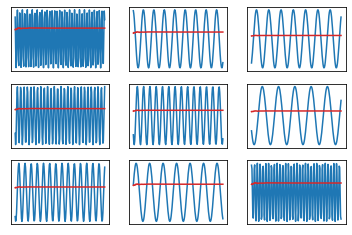

In [ ]:
# DATA GENERATION
def audio_data_generation(audio_wav, duration_sample, batch_size):

    # dataset loading
    dataset = DataSetAudio_1D(audio_wavfile=audio_wav, duration_sample= duration_sample)
    samples = dataset.samples

    # train test split
    # split = int(load_data.shape[0] * 0.7)
    # print('split', split)

    # dataloader creation
    train_dataloader = DataLoader(dataset, batch_size)
    test_dataloader = DataLoader(dataset, batch_size)

    return train_dataloader, test_dataloader, samples


def sinus_data_generation(nb_examples, fs , freq_range, len_sample, batch_size):

    # dataset loading
    train_dataset = SinusSamplesDataset(nb_examples=nb_examples, fs=fs, frequency_range=freq_range, len_sinus=len_sample)
    samples = train_dataset.samples
    print('Sinus train dataset done!')

    # train test split
    split = int(nb_examples * 0.3)
    # print('split', split)
    test_dataset = SinusSamplesDataset(nb_examples=split, fs=fs, frequency_range=freq_range,
                                        len_sinus=len_sample)
    print('Sinus test dataset done!')

    # dataloader creation
    train_dataloader = DataLoader(train_dataset, batch_size)
    test_dataloader = DataLoader(test_dataset, batch_size)

    return train_dataloader, test_dataloader, samples


def training(dataloader, testloader, model, lr, epochs):

    print('Starting the training')

    # make list for the plot
    loss_list = []
    val_loss_list = []
    epochs_list = []

    # optimizer and loss
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    model = model.float()

    for epoch in range(epochs):
        loss = 0
        val_loss = 0
        for i, batch_features in enumerate(dataloader, 0):

            # reset the gradients back to zero
            # PyTorch accumulates gradients on subsequent backward passes
            optimizer.zero_grad()

            # compute reconstructions
            # print(batch_features.shape)
            # batch_features = Variable(batch_features, requires_grad=True)
            batch_features = batch_features.float()
            batch_features = batch_features.to(device)

            outputs = model(batch_features)

            # compute training reconstruction loss
            train_loss = criterion(outputs, batch_features)

            # compute accumulated gradients
            train_loss.backward()

            # perform parameter update based on current gradients
            optimizer.step()

            # add the mini-batch training loss to epoch loss
            loss += train_loss.item()

        # compute the epoch training loss
        loss = loss / len(dataloader)

        # compute the validation loss
        with torch.no_grad():
            for i, test_features in enumerate(testloader, 0):
                test_features = test_features.float()
                test_features = test_features.to(device)
                outputs = model(test_features)
                test_loss = criterion(outputs, test_features)
                val_loss += test_loss.item()

        # compute the epoch validation loss
        val_loss = val_loss/len(testloader)

        # update lists
        loss_list.append(loss)
        val_loss_list.append(val_loss)
        epochs_list.append(epoch)

        # display the epoch training loss
        print("epoch : {}/{}, loss = {:.6f}, validation loss = {:.6f}".format(epoch + 1, epochs, loss, val_loss))

    plt.plot(epochs_list, loss_list, label='loss')
    plt.plot(epochs_list, val_loss_list, label='validation loss')
    plt.legend()
    plt.show()

    print("Trained Model!")

    return model


def test_prediction(data, model):

    fig, ax = plt.subplots(3, 3)
    for ii in range(3):
        for jj in range(3):
            # data shape = (X, 2, 11000)

            data_sample = data[ii * 100 + jj + 50]  # (2, 11000)
            data_sample = torch.unsqueeze(data_sample, dim=0)  # (1, 2, 11000)
            model = model.float()
            data_sample = data_sample.to(device)
            prediction = model(data_sample.float())  # (1, 2, 11000)

            # remove 1st fim -> (2, 11000)
            prediction = torch.squeeze(prediction)
            data_sample = torch.squeeze(data_sample)

            # torch.Tensor -> numpy.array
            prediction = prediction.cpu()
            prediction = prediction.detach().numpy()
            data_sample = data_sample.cpu()
            data_sample = data_sample.numpy()

            ax[ii, jj].plot(data_sample[1][:200], color="tab:blue")
            ax[ii, jj].plot(prediction[1][:200], color="tab:red")
            ax[ii, jj].set_xticks([])
            ax[ii, jj].set_yticks([])
    plt.show()
    pass


def run(model, data_type, data_parameter, batch_size, nb_epochs, train, save, savename, load, loadname):

    if data_type == 'audio':
        train_loader, test_loader, samples = audio_data_generation(audio_wav=data_parameter[0],
                                                                   duration_sample=data_parameter[1],
                                                                   batch_size=batch_size)

    if data_type == 'sinus':
        train_loader, test_loader, samples = sinus_data_generation(nb_examples=data_parameter[0],
                                                                   fs=data_parameter[1],
                                                                   freq_range=data_parameter[2],
                                                                   len_sample=data_parameter[3],
                                                                   batch_size=batch_size)

    if train == True:
        trained_model = training(train_loader, test_loader, model, lr=0.001, epochs=nb_epochs)

    if save==True:
        torch.save(trained_model, savename)
        print('Model saved!')

    if load==True:
        model = torch.load('../models/'+loadname)
        model.eval()

    test_prediction(samples, model)
    pass


if __name__ == '__main__':

    kernel_size = 13
    padding = int(kernel_size/2)
    model = AutoEncoder_1D(kernel_size=kernel_size,
                           padding=padding)
    model = model.to(device)

    data_type = 'sinus'

    if data_type == 'audio':
        audio = 'audio_data/caroleeg_perf1.wav'
        duration_sample = 1
        data_param = [audio, duration_sample]

    if data_type == 'sinus':
        nb_examples = 1000
        fs = 11000
        freq_range = [200, 2000]
        len_sample = 11000
        data_param = [nb_examples, fs, freq_range, len_sample]

    batch_size = 16
    nb_epochs = 100

    train = False

    save = False
    savename = 'raw_audio_encoder_1D_sinus_200_2000Hz_13kernels_100epochs.pt'

    load = False
    loadname = 'raw_audio_encoder_1D_sinus_200_1000Hz.pt'

    run(model, data_type=data_type, data_parameter=data_param, batch_size=batch_size, nb_epochs=nb_epochs,
        train=train, save=save, savename=savename, load=load, loadname=loadname)

# Piano samples

## Load data

In [ ]:
!wget http://deepyeti.ucsd.edu/cdonahue/wavegan/data/mancini_piano.tar.gz

--2021-03-18 10:51:34--  http://deepyeti.ucsd.edu/cdonahue/wavegan/data/mancini_piano.tar.gz
Resolving deepyeti.ucsd.edu (deepyeti.ucsd.edu)... 169.228.63.50
Connecting to deepyeti.ucsd.edu (deepyeti.ucsd.edu)|169.228.63.50|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 433417623 (413M) [application/octet-stream]
Saving to: ‘mancini_piano.tar.gz.3’

mancini_piano.tar.g 100%[===================>] 413.34M  39.4MB/s    in 11s     

2021-03-18 10:51:45 (37.9 MB/s) - ‘mancini_piano.tar.gz.3’ saved [433417623/433417623]



In [ ]:
!tar -xvf mancini_piano.tar.gz

piano/test/
piano/test/17.wav
piano/test/18.wav
piano/train/
piano/train/00.wav
piano/train/01.wav
piano/train/02.wav
piano/train/03.wav
piano/train/04.wav
piano/train/05.wav
piano/train/06.wav
piano/train/07.wav
piano/train/08.wav
piano/train/09.wav
piano/train/10.wav
piano/train/11.wav
piano/train/12.wav
piano/train/13.wav
piano/train/14.wav
piano/valid/
piano/valid/15.wav
piano/valid/16.wav


## Dataset

In [ ]:
import librosa
import scipy
import numpy as np
import torch
from torch.utils.data import Dataset

In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")  # you can continue going on here, like cuda:1 cuda:2....etc. 
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

Running on the GPU


In [ ]:
class DataSetAudio_1D (Dataset) :

    def __init__(self, audio_wavfile, duration_sample):
        self.audio = audio_wavfile
        self.duration = duration_sample
        self.samples, self.len_sample, self.nb_samples = self.segment_audio(self.audio, self.duration)

    def __len__(self):
        return self.samples.size()[0]

    def __getitem__(self, item):
        return self.samples[item]

    def segment_audio(self, audio_wavfile, duration_sample):
        # load signal
        signal, init_sr = librosa.core.load(audio_wavfile, sr=None, mono=False)

        # seperate the two stereo band
        signal_stereo_1 = signal[0]
        signal_stereo_2 = signal[1]

        # resample 44 100 Hz -> 11 000 Hz
        len_signal = signal.shape[1]
        sr = 11000
        nb_points_resample = int((sr / init_sr) * len_signal)

        signal_stereo_1 = scipy.signal.resample(signal_stereo_1, nb_points_resample)
        signal_stereo_2 = scipy.signal.resample(signal_stereo_2, nb_points_resample)

        signal = np.array((signal_stereo_1, signal_stereo_2))

        # convert duration_sample in nb points
        len_sample = duration_sample * sr
        nb_samples = int(signal.shape[1] / len_sample)

        # create samples
        samples = np.zeros((nb_samples, 2, len_sample))
        idx_start = 0
        for num_sample in range(nb_samples):
            samples[num_sample][0] = signal_stereo_1[idx_start: idx_start + len_sample]
            samples[num_sample][1] = signal_stereo_1[idx_start: idx_start + len_sample]
            idx_start += len_sample

        # convert samples to torch.Tensor
        samples_tensor = torch.from_numpy(samples)

        return samples_tensor, len_sample, nb_samples

## Autoencoder

In [ ]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1" 

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch
from torchsummary import summary

### Fixed kernel size

In [ ]:
class AutoEncoder_1D(nn.Module):

    def __init__(self, kernel_size, padding):
        super(AutoEncoder_1D, self).__init__()
        # input size = (batch_size, 2, len_sample=11000)

        # encoder
        self.pad = nn.ZeroPad2d(padding=(4, 4, 0, 0))  # (2, 11008)
        self.conv1 = nn.Conv1d(2, 64, kernel_size=kernel_size, padding=padding)  # (64, 11008)
        self.conv2 = nn.Conv1d(64, 32, kernel_size=kernel_size, padding=padding)  # (32, 5504)
        self.conv3 = nn.Conv1d(32, 4, kernel_size=kernel_size, padding=padding)  # (4, 2752)
        self.conv4 = nn.Conv1d(4, 2, kernel_size=kernel_size, padding=padding)  # (2, 1376)

        # decoder
        self.inv_conv1 = nn.ConvTranspose1d(2, 2, kernel_size=kernel_size, padding=padding)  # (2, 688)
        self.up1 = nn.Upsample(scale_factor=2)  # (2, 1376)
        self.inv_conv2 = nn.ConvTranspose1d(2, 4, kernel_size=kernel_size, padding=padding)  # (4, 1376)
        self.up2 = nn.Upsample(scale_factor=2)  # (4, 2752)
        self.inv_conv3 = nn.ConvTranspose1d(4, 32, kernel_size=kernel_size, padding=padding)  # (32, 2752)
        self.up3 = nn.Upsample(scale_factor=2)  # (32, 5504)
        self.inv_conv4 = nn.ConvTranspose1d(32, 64, kernel_size=kernel_size, padding=padding)  # (64, 5504)
        self.up4 = nn.Upsample(scale_factor=2)  # (64, 11008)
        self.inv_conv5 = nn.ConvTranspose1d(64, 2, kernel_size=kernel_size, padding=padding)  # (2, 11008)

    def encoder(self, x):
        # print(x.shape)
        x = self.pad(x)
        # print(x.shape)
        x = F.avg_pool2d(F.relu(self.conv1(x)), kernel_size=(1, 2))  # (64, 5504)
        # print(x.shape)
        x = F.avg_pool2d(F.relu(self.conv2(x)), (1, 2))  # (32, 2752)
        # print(x.shape)
        x = F.avg_pool2d(F.relu(self.conv3(x)), (1, 2))  # (4, 1376)
        # print(x.shape)
        x = F.avg_pool2d(F.relu(self.conv4(x)), (1, 2))  # (2, 688)
        # print(x.shape)

        return x

    def decoder(self, x):
        # print(x.shape)
        x = self.up1(F.relu(self.inv_conv1(x)))
        # print(x.shape)
        x = self.up2(F.relu(self.inv_conv2(x)))
        # print(x.shape)
        x = self.up3(F.relu(self.inv_conv3(x)))
        # print(x.shape)
        x = self.up4(F.relu(self.inv_conv4(x)))
        # print(x.shape)
        x = self.inv_conv5(x)
        # print(x.shape)
        x = x[:, :, 4: 11004]
        # print(x.shape)
        return x

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)

        return x

### Variable kernel size

In [ ]:
class AutoEncoder_1D_VarKernel(nn.Module):

    def __init__(self, kernel_size, padding):
        super(AutoEncoder_1D_VarKernel, self).__init__()
        # input size = (batch_size, 2, len_sample=11000)

        # encoder
        self.pad = nn.ZeroPad2d(padding=(4, 4, 0, 0))  # (2, 11008)
        self.conv1 = nn.Conv1d(2, 64, kernel_size=kernel_size[0], padding=padding[0])  # (64, 11008)
        self.conv2 = nn.Conv1d(64, 32, kernel_size=kernel_size[1], padding=padding[1])  # (32, 5504)
        self.conv3 = nn.Conv1d(32, 4, kernel_size=kernel_size[2], padding=padding[2])  # (4, 2752)
        self.conv4 = nn.Conv1d(4, 2, kernel_size=kernel_size[3], padding=padding[3])  # (2, 1376)

        # decoder
        self.inv_conv1 = nn.ConvTranspose1d(2, 2, kernel_size=kernel_size[3], padding=padding[3])  # (2, 688)
        self.up1 = nn.Upsample(scale_factor=2)  # (2, 1376)
        self.inv_conv2 = nn.ConvTranspose1d(2, 4, kernel_size=kernel_size[2], padding=padding[2])  # (4, 1376)
        self.up2 = nn.Upsample(scale_factor=2)  # (4, 2752)
        self.inv_conv3 = nn.ConvTranspose1d(4, 32, kernel_size=kernel_size[1], padding=padding[1])  # (32, 2752)
        self.up3 = nn.Upsample(scale_factor=2)  # (32, 5504)
        self.inv_conv4 = nn.ConvTranspose1d(32, 64, kernel_size=kernel_size[0], padding=padding[0])  # (64, 5504)
        self.up4 = nn.Upsample(scale_factor=2)  # (64, 11008)
        self.inv_conv5 = nn.ConvTranspose1d(64, 2, kernel_size=kernel_size[0], padding=padding[0])  # (2, 11008)

    def encoder(self, x):
        # print(x.shape)
        x = self.pad(x)
        # print(x.shape)
        x = F.avg_pool2d(F.relu(self.conv1(x)), kernel_size=(1, 2))  # (64, 5504)
        # print(x.shape)
        x = F.avg_pool2d(F.relu(self.conv2(x)), (1, 2))  # (32, 2752)
        # print(x.shape)
        x = F.avg_pool2d(F.relu(self.conv3(x)), (1, 2))  # (4, 1376)
        # print(x.shape)
        x = F.avg_pool2d(F.relu(self.conv4(x)), (1, 2))  # (2, 688)
        # print(x.shape)

        return x

    def decoder(self, x):
        # print(x.shape)
        x = self.up1(F.relu(self.inv_conv1(x)))
        # print(x.shape)
        x = self.up2(F.relu(self.inv_conv2(x)))
        # print(x.shape)
        x = self.up3(F.relu(self.inv_conv3(x)))
        # print(x.shape)
        x = self.up4(F.relu(self.inv_conv4(x)))
        # print(x.shape)
        x = self.inv_conv5(x)
        # print(x.shape)
        x = x[:, :, 4: 11004]
        # print(x.shape)
        return x

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)

        return x

### VAE

In [ ]:
class VAE_VarKernel(nn.Module):

    def __init__(self, kernel_size, padding):
        super(VAE_VarKernel, self).__init__()
        # input size = (batch_size, 2, len_sample=11000)

        # encoder
        self.pad = nn.ZeroPad2d(padding=(4, 4, 0, 0))  # (2, 11008)
        self.conv1 = nn.Conv1d(2, 64, kernel_size=kernel_size[0], padding=padding[0])  # (64, 11008)
        # torch.nn.init.xavier_uniform(self.conv1.weight)
        self.conv2 = nn.Conv1d(64, 32, kernel_size=kernel_size[1], padding=padding[1])  # (32, 5504)
        self.conv3 = nn.Conv1d(32, 4, kernel_size=kernel_size[2], padding=padding[2])  # (4, 2752)
        self.conv4 = nn.Conv1d(4, 2, kernel_size=kernel_size[3], padding=padding[3])  # (2, 1376)
        self.flatt = nn.Flatten() # (2*688 = 1376)

        # bottleneck
        self.fc11 = nn.Linear(1376, 20)
        self.fc12 = nn.Linear(1376, 20)
        self.fc2 = nn.Linear(20, 1376)

        # decoder
        self.unflatt = nn.Unflatten(1, (2, 688))  # (2, 688)
        self.inv_conv1 = nn.ConvTranspose1d(2, 2, kernel_size=kernel_size[3], padding=padding[3])  # (2, 688)
        self.up1 = nn.Upsample(scale_factor=2)  # (2, 1376)
        self.inv_conv2 = nn.ConvTranspose1d(2, 4, kernel_size=kernel_size[2], padding=padding[2])  # (4, 1376)
        self.up2 = nn.Upsample(scale_factor=2)  # (4, 2752)
        self.inv_conv3 = nn.ConvTranspose1d(4, 32, kernel_size=kernel_size[1], padding=padding[1])  # (32, 2752)
        self.up3 = nn.Upsample(scale_factor=2)  # (32, 5504)
        self.inv_conv4 = nn.ConvTranspose1d(32, 64, kernel_size=kernel_size[0], padding=padding[0])  # (64, 5504)
        self.up4 = nn.Upsample(scale_factor=2)  # (64, 11008)
        self.inv_conv5 = nn.ConvTranspose1d(64, 2, kernel_size=kernel_size[0], padding=padding[0])  # (2, 11008)

    def encoder(self, x):
        # print(x.shape)
        x = self.pad(x)
        # print(x.shape)
        x = F.avg_pool2d(F.relu(self.conv1(x)), kernel_size=(1, 2))  # (64, 5504)
        # print(x.shape)
        x = F.avg_pool2d(F.relu(self.conv2(x)), (1, 2))  # (32, 2752)
        # print(x.shape)
        x = F.avg_pool2d(F.relu(self.conv3(x)), (1, 2))  # (4, 1376)
        # print(x.shape)
        x = F.avg_pool2d(F.relu(self.conv4(x)), (1, 2))  # (2, 688)
        # print(x.shape)
        x = self.flatt(x)  # (1376)

        return x

    def decoder(self, x):
        x = self.unflatt(x)  # (2, 688)
        # print(x.shape)
        x = self.up1(F.relu(self.inv_conv1(x)))
        # print(x.shape)
        x = self.up2(F.relu(self.inv_conv2(x)))
        # print(x.shape)
        x = self.up3(F.relu(self.inv_conv3(x)))
        # print(x.shape)
        x = self.up4(F.relu(self.inv_conv4(x)))
        # print(x.shape)
        x = self.inv_conv5(x)
        # print(x.shape)
        x = x[:, :, 4: 11004]
        # print(x.shape)
        return x

    def forward(self, x):
        h = self.encoder(x)
        z, mu, logvar = self.bottleneck(h)
        z = self.fc2(z)

        return self.decoder(z), mu, logvar
    
    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        # return torch.normal(mu, std)
        esp = torch.randn(*mu.size())
        std = std.to(device)
        esp = esp.to(device)
        mu = mu.to(device)
        z = mu + std * esp
        z = z.to(device)
        return z

    def bottleneck(self, h):
        mu, logvar = self.fc11(h), self.fc12(h)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar

    def representation(self, x):
        return self.bottleneck(self.encoder(x))[0]

## Train

In [ ]:
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib.pyplot as plt
import scipy.io.wavfile as wavfile

### Train for Autoencoders

Datasets done!


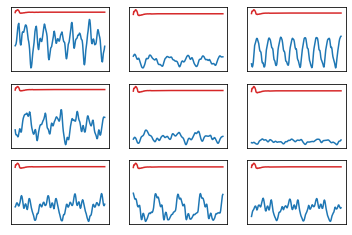

In [ ]:
# DATA GENERATION
def audio_data_generation(duration_sample, batch_size):

    # dataset loading
    # make Dataset of each piano/train/ wav file and gather them in one dataset
    train_datasets = []
    for i in range(15):
      if i<10:
        train_datasets.append(DataSetAudio_1D(f'piano/train/0{i}.wav', duration_sample=duration_sample))
      else:
        train_datasets.append(DataSetAudio_1D(f'piano/train/{i}.wav', duration_sample=duration_sample))

    train_dataset = torch.utils.data.ConcatDataset(train_datasets)

    # test dataset
    test_datasets = []
    list_samples = []
    len_test_samples = []
    for i in range(17, 19):
      dataset = DataSetAudio_1D(f'piano/test/{i}.wav', duration_sample=duration_sample)
      list_samples.append(dataset.samples)
      test_datasets.append(dataset)
      len_test_samples.append(dataset.nb_samples)

    samples = torch.cat((list_samples[0], list_samples[1]))
      
    test_dataset = torch.utils.data.ConcatDataset(test_datasets)

    # dataloader creation
    train_dataloader = DataLoader(train_dataset, batch_size)
    test_dataloader = DataLoader(test_dataset, batch_size=1)

    return train_dataloader, test_dataloader, samples, len_test_samples



def training(dataloader, testloader, model, lr, epochs):

    print('Starting the training')

    # make list for the plot
    loss_list = []
    val_loss_list = []
    epochs_list = []

    # optimizer and loss
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    model = model.float()

    for epoch in range(epochs):
        loss = 0
        val_loss = 0
        for i, batch_features in enumerate(dataloader, 0):

            # reset the gradients back to zero
            # PyTorch accumulates gradients on subsequent backward passes
            optimizer.zero_grad()

            # compute reconstructions
            # print(batch_features.shape)
            # batch_features = Variable(batch_features, requires_grad=True)
            batch_features = batch_features.float()
            batch_features = batch_features.to(device)

            outputs = model(batch_features)

            # compute training reconstruction loss
            train_loss = criterion(outputs, batch_features)

            # compute accumulated gradients
            train_loss.backward()

            # perform parameter update based on current gradients
            optimizer.step()

            # add the mini-batch training loss to epoch loss
            loss += train_loss.item()

        # compute the epoch training loss
        loss = loss / len(dataloader)

        # compute the validation loss
        with torch.no_grad():
            for i, test_features in enumerate(testloader, 0):
                test_features = test_features.float()
                test_features = test_features.to(device)
                outputs = model(test_features)
                test_loss = criterion(outputs, test_features)
                val_loss += test_loss.item()

        # compute the epoch validation loss
        val_loss = val_loss/len(testloader)

        # update lists
        loss_list.append(loss)
        val_loss_list.append(val_loss)
        epochs_list.append(epoch)

        # display the epoch training loss
        print("epoch : {}/{}, loss = {:.6f}, validation loss = {:.6f}".format(epoch + 1, epochs, loss, val_loss))

    plt.plot(epochs_list, loss_list, label='loss')
    plt.plot(epochs_list, val_loss_list, label='validation loss')
    plt.legend()
    plt.show()

    print("Trained Model!")

    return model


def test_prediction(data, model):

    fig, ax = plt.subplots(3, 3)
    for ii in range(3):
        for jj in range(3):
            # data shape = (X, 2, 11000)

            data_sample = data[ii * 50 + jj + 50]  # (2, 11000)
            data_sample = torch.unsqueeze(data_sample, dim=0)  # (1, 2, 11000)
            model = model.float()
            data_sample = data_sample.to(device)
            prediction = model(data_sample.float())  # (1, 2, 11000)

            # remove 1st fim -> (2, 11000)
            prediction = torch.squeeze(prediction)
            data_sample = torch.squeeze(data_sample)

            # torch.Tensor -> numpy.array
            prediction = prediction.cpu()
            prediction = prediction.detach().numpy()
            data_sample = data_sample.cpu()
            data_sample = data_sample.numpy()

            # from_array_to_wav(data_sample, 11000,'input_output/'+f'input{ii * 50 + jj + 50}')
            # from_array_to_wav(prediction, 11000,'input_output/'+f'output{ii * 50 + jj + 50}')

            ax[ii, jj].plot(data_sample[1][:200], color="tab:blue")
            ax[ii, jj].plot(prediction[1][:200], color="tab:red")
            ax[ii, jj].set_xticks([])
            ax[ii, jj].set_yticks([])
    plt.show()
    pass


def visualization_latent_space(model, test_loader, samples):

    # get the number of examples
    N = samples.shape[0]

    # create array with output encoder
    test_encoded = np.zeros((N, 2, 1))

    with torch.no_grad():
        for i, test_features in enumerate(test_loader, 0):

            # set the input to go to encoder
            test_features = test_features.float()
            test_features = test_features.to(device)

            # pass the input in the encoder
            outputs_encoder = model.encoder(test_features)

            # transform the output in np.array
            outputs_encoder = outputs_encoder.cpu()
            outputs_encoder = outputs_encoder.detach().numpy()
            outputs_encoder = outputs_encoder[0]

            # take the average of temporal values
            outputs_encoder = np.mean(outputs_encoder, axis=1, keepdims=True)

            # save it
            test_encoded[i] = outputs_encoder

    # test_freqs_t = np.matlib.repmat(frequencies, 688, 1)
    plt.scatter(test_encoded[:, 0, :], test_encoded[:, 1, :])
    plt.show()

    pass


def reconstruct_audio(data, len_samples, model):
    num_ex = 17
    for nb_samples in len_samples:
      audio = np.zeros((2, nb_samples*11000))
      for ii in range(nb_samples):
          if num_ex ==17:
            data_sample = data[ii]  # (2, 11000)
          else:
            data_sample = data[len_samples[0] + ii]  # (2, 11000)
          data_sample = torch.unsqueeze(data_sample, dim=0)  # (1, 2, 11000)
          model = model.float()
          data_sample = data_sample.to(device)
          prediction = model(data_sample.float())  # (1, 2, 11000)

          # remove 1st fim -> (2, 11000)
          prediction = torch.squeeze(prediction)

          # torch.Tensor -> numpy.array
          prediction = prediction.cpu()
          prediction = prediction.detach().numpy()

          # add to audio array
          audio[0][ii*11000:((ii+1)*11000)] = prediction[0]
          audio[1][ii*11000:((ii+1)*11000)] = prediction[1]

      from_array_to_wav(audio, 11000,f'test_{num_ex}')
      num_ex += 1
    pass


def from_array_to_wav(sound_array, fs, name):
    # sound array is (2, 11000) and we want (11000, 2)
    sound_array = np.transpose(sound_array)
    wavfile.write(name + '_stereo.wav', rate=fs, data=sound_array)
    pass


def run(model, lr, time_sample, batch_size, nb_epochs, train, save, savename, load, loadname):

    
    train_loader, test_loader, test_samples, test_samples_nb = audio_data_generation(duration_sample=time_sample,
                                                                batch_size=batch_size)
    print('Datasets done!')


    if train == True:
        print('Begining training!')
        trained_model = training(train_loader, test_loader, model, lr=lr, epochs=nb_epochs)

    if save==True:
        torch.save(trained_model, savename)
        print('Model saved!')

    if load==True:
        model = torch.load(loadname)
        model.eval()
        print('Model loaded!')

        if latent_space == True:
          visualization_latent_space(model, test_loader=test_loader, samples=test_samples)

    reconstruct_audio(test_samples, test_samples_nb, model)
    test_prediction(test_samples, model)
    pass


if __name__ == '__main__':

    model_kernel_values = 'variable' # 'variable' or 'constant'

    if model_kernel_values == 'constant':
      kernel_size = 13
      padding = int(kernel_size/2)
      model = AutoEncoder_1D(kernel_size=kernel_size,
                            padding=padding)
      model = model.to(device)
    
    if model_kernel_values == 'variable':
      kernel_size = [13, 11, 7, 5]
      padding=[6, 5, 3, 2]
      model = AutoEncoder_1D_VarKernel(kernel_size=kernel_size,
                            padding=padding)
      model = model.to(device)

    learning_rate = 0.001 # 0.001
    duration_sample = 1
    

    batch_size = 16
    nb_epochs = 100

    train = False

    save = False
    savename = 'raw_audio_encoder_1D_piano_variablekernel_100epochs.pt'

    load = False
    loadname = 'raw_audio_encoder_1D_piano_variablekernel_100epochs.pt'

    latent_space = False

    run(model, lr=learning_rate, time_sample=duration_sample, batch_size=batch_size, nb_epochs=nb_epochs,
        train=train, save=save, savename=savename, load=load, loadname=loadname)

### Train for VAE

In [ ]:
# DATA GENERATION
def audio_data_generation(duration_sample, batch_size):

    # dataset loading
    # make Dataset of each piano/train/ wav file and gather them in one dataset
    train_datasets = []
    for i in range(15):
      if i<10:
        train_datasets.append(DataSetAudio_1D(f'piano/train/0{i}.wav', duration_sample=duration_sample))
      else:
        train_datasets.append(DataSetAudio_1D(f'piano/train/{i}.wav', duration_sample=duration_sample))

    train_dataset = torch.utils.data.ConcatDataset(train_datasets)

    # test dataset
    test_datasets = []
    list_samples = []
    len_test_samples = []
    for i in range(17, 19):
      dataset = DataSetAudio_1D(f'piano/test/{i}.wav', duration_sample=duration_sample)
      list_samples.append(dataset.samples)
      test_datasets.append(dataset)
      len_test_samples.append(dataset.nb_samples)

    samples = torch.cat((list_samples[0], list_samples[1]))
      
    test_dataset = torch.utils.data.ConcatDataset(test_datasets)

    # dataloader creation
    train_dataloader = DataLoader(train_dataset, batch_size)
    test_dataloader = DataLoader(test_dataset, batch_size=1)

    return train_dataloader, test_dataloader, samples, len_test_samples

def loss_fn(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, size_average=False)
    # BCE = F.cross_entropy(recon_x, x, size_average=False)
    # BCE = F.mse_loss(recon_x, x, size_average=False)

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD, BCE, KLD



def training(dataloader, testloader, model, lr, epochs):

    print('Starting the training')

    # make list for the plot
    loss_list = []
    val_loss_list = []
    epochs_list = []

    # optimizer and loss
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    model = model.float()

    for epoch in range(epochs):
        loss = 0
        val_loss = 0
        for i, batch_features in enumerate(dataloader, 0):

            # reset the gradients back to zero
            # PyTorch accumulates gradients on subsequent backward passes
            optimizer.zero_grad()

            # compute reconstructions
            # print(batch_features.shape)
            # batch_features = Variable(batch_features, requires_grad=True)
            batch_features = batch_features.float()
            batch_features = batch_features.to(device)

            outputs, mu, logvar = model(batch_features)

            # compute training reconstruction loss
            train_loss, bce, kld = loss_fn(outputs, batch_features, mu, logvar) 
            # print(type(criterion(outputs, batch_features)))
            # print(criterion(outputs, batch_features))
            # train_loss+= criterion(outputs, batch_features)

            # compute accumulated gradients
            train_loss.backward()

            # perform parameter update based on current gradients
            optimizer.step()

            # add the mini-batch training loss to epoch loss
            loss += train_loss.item()

        # compute the epoch training loss
        loss = loss / len(dataloader)

        # compute the validation loss
        with torch.no_grad():
            for i, test_features in enumerate(testloader, 0):
                test_features = test_features.float()
                test_features = test_features.to(device)
                outputs, mu, logvar = model(test_features)
                test_loss, bce, kld = loss_fn(outputs, test_features, mu, logvar)
                val_loss += test_loss.item()

        # compute the epoch validation loss
        val_loss = val_loss/len(testloader)

        # update lists
        loss_list.append(loss)
        val_loss_list.append(val_loss)
        epochs_list.append(epoch)

        # display the epoch training loss
        print("epoch : {}/{}, loss = {:.6f}, validation loss = {:.6f}".format(epoch + 1, epochs, loss, val_loss))

    plt.plot(epochs_list, loss_list, label='loss')
    plt.plot(epochs_list, val_loss_list, label='validation loss')
    plt.legend()
    plt.show()

    print("Trained Model!")

    return model


def test_prediction(data, model):

    fig, ax = plt.subplots(3, 3)
    for ii in range(3):
        for jj in range(3):
            # data shape = (X, 2, 11000)

            data_sample = data[ii * 50 + jj + 50]  # (2, 11000)
            data_sample = torch.unsqueeze(data_sample, dim=0)  # (1, 2, 11000)
            model = model.float()
            data_sample = data_sample.to(device)
            prediction, mu, logvar = model(data_sample.float())  # (1, 2, 11000)

            # remove 1st fim -> (2, 11000)
            prediction = torch.squeeze(prediction)
            data_sample = torch.squeeze(data_sample)

            # torch.Tensor -> numpy.array
            prediction = prediction.cpu()
            prediction = prediction.detach().numpy()
            data_sample = data_sample.cpu()
            data_sample = data_sample.numpy()

            # from_array_to_wav(data_sample, 11000,'input_output/'+f'input{ii * 50 + jj + 50}')
            # from_array_to_wav(prediction, 11000,'input_output/'+f'output{ii * 50 + jj + 50}')

            ax[ii, jj].plot(data_sample[1][:200], color="tab:blue")
            ax[ii, jj].plot(prediction[1][:200], color="tab:red")
            ax[ii, jj].set_xticks([])
            ax[ii, jj].set_yticks([])
    plt.show()
    pass


def visualization_latent_space(model, test_loader, samples):

    # get the number of examples
    N = samples.shape[0]

    # create array with output encoder
    test_encoded = np.zeros((N, 2, 1))

    with torch.no_grad():
        for i, test_features in enumerate(test_loader, 0):

            # set the input to go to encoder
            test_features = test_features.float()
            test_features = test_features.to(device)

            # pass the input in the encoder
            outputs_encoder, mu, logvar = model.encoder(test_features)

            # transform the output in np.array
            outputs_encoder = outputs_encoder.cpu()
            outputs_encoder = outputs_encoder.detach().numpy()
            outputs_encoder = outputs_encoder[0]

            # take the average of temporal values
            outputs_encoder = np.mean(outputs_encoder, axis=1, keepdims=True)

            # save it
            test_encoded[i] = outputs_encoder

    # test_freqs_t = np.matlib.repmat(frequencies, 688, 1)
    plt.scatter(test_encoded[:, 0, :], test_encoded[:, 1, :])
    plt.show()

    pass


def reconstruct_audio(data, len_samples, model):
    num_ex = 17
    for nb_samples in len_samples:
      audio = np.zeros((2, nb_samples*11000))
      for ii in range(nb_samples):
          if num_ex ==17:
            data_sample = data[ii]  # (2, 11000)
          else:
            data_sample = data[len_samples[0] + ii]  # (2, 11000)
          data_sample = torch.unsqueeze(data_sample, dim=0)  # (1, 2, 11000)
          model = model.float()
          data_sample = data_sample.to(device)
          prediction, mu, logvar = model(data_sample.float())  # (1, 2, 11000)

          # remove 1st fim -> (2, 11000)
          prediction = torch.squeeze(prediction)

          # torch.Tensor -> numpy.array
          prediction = prediction.cpu()
          prediction = prediction.detach().numpy()

          # add to audio array
          audio[0][ii*11000:((ii+1)*11000)] = prediction[0]
          audio[1][ii*11000:((ii+1)*11000)] = prediction[1]

      from_array_to_wav(audio, 11000,f'test_{num_ex}')
      num_ex += 1
    pass


def from_array_to_wav(sound_array, fs, name):
    # sound array is (2, 11000) and we want (11000, 2)
    sound_array = np.transpose(sound_array)
    wavfile.write(name + '_stereo.wav', rate=fs, data=sound_array)
    pass


def run(model, lr, time_sample, batch_size, nb_epochs, train, save, savename, load, loadname):

    
    train_loader, test_loader, test_samples, test_samples_nb = audio_data_generation(duration_sample=time_sample,
                                                                batch_size=batch_size)
    print('Datasets done!')


    if train == True:
        print('Begining training!')
        trained_model = training(train_loader, test_loader, model, lr=lr, epochs=nb_epochs)

    if save==True:
        torch.save(trained_model, savename)
        print('Model saved!')

    if load==True:
        model = torch.load(loadname)
        model.eval()
        print('Model loaded!')

        if latent_space == True:
          visualization_latent_space(model, test_loader=test_loader, samples=test_samples)

    # reconstruct_audio(test_samples, test_samples_nb, model)
    test_prediction(test_samples, model)
    pass


if __name__ == '__main__':

  if torch.cuda.is_available():
    device = torch.device("cuda:0")  # you can continue going on here, like cuda:1 cuda:2....etc. 
    print("Running on the GPU")
  else:
    device = torch.device("cpu")
    print("Running on the CPU")
    
  kernel_size = [13, 11, 7, 5]
  padding=[6, 5, 3, 2]
  model = VAE_VarKernel(kernel_size=kernel_size,
                        padding=padding)
  model = model.to(device)

  learning_rate = 0.001 # 0.001
  duration_sample = 1
  

  batch_size = 16
  nb_epochs = 100

  train = True

  save = False
  savename = 'raw_audio_encoder_1D_piano_variablekernel_100epochs.pt'

  load = False
  loadname = 'raw_audio_encoder_1D_piano_variablekernel_100epochs.pt'

  latent_space = False

  run(model, lr=learning_rate, time_sample=duration_sample, batch_size=batch_size, nb_epochs=nb_epochs,
      train=train, save=save, savename=savename, load=load, loadname=loadname)

Running on the GPU


RuntimeError: ignored

## Audio generation

In [ ]:
import torch
import matplotlib.pyplot as plt
import scipy.io.wavfile as wavfile
import numpy as np

In [ ]:
def generate_data(model, nb_samples):
    #
    ### generate random input
    #

    # define mean and std
    mean_1 = 9.7
    mean_2 = 7.2

    std_1 = 0.1
    std_2 = 0.1

    # create each channel
    input_1 = torch.normal(mean=mean_1, std=std_1, size=(1, 688))  # shape (1, 688)
    input_2 = torch.normal(mean=mean_2, std=std_2, size=(1, 688))  # shape (1, 688)

    # join the two 
    input = torch.cat((input_1, input_2))

    # add first dim -> (1, 2, 688)
    input = torch.unsqueeze(input, 0)
    input = input.to(device)
    # input goes through the decoder
    output = model.decoder(input)  # shape (1, 2, 11000)
    output = output.to(device)

    # remove the 1st dimension -> (2, 11000)
    output = torch.squeeze(output)
    output = output.cpu()
    output = output.detach().numpy()
    print(output.shape)

    plt.plot(output[0], color="tab:red")
    plt.plot(output[1], color="tab:blue")
    plt.show()
    return output, mean_1, mean_2


def from_array_to_wav(sound_array, fs, name):
    # sound array is (2, 11000) and we want (11000, 2)
    sound_array = np.transpose(sound_array)
    wavfile.write(name + '_stereo.wav', rate=fs, data=sound_array)
    pass

if __name__ == '__main__':
    # load trained model and sinus data
    model_name = 'raw_audio_encoder_1D_piano_variablekernel_100epochs.pt'
    model = torch.load(model_name)
    model.eval()
    output, mean1, mean2 = generate_data(model, nb_samples=1)
    from_array_to_wav(output, 11000, f'testX_mean({mean1},{mean2})')

# BrainSong samples


to do...
